## PSF quantification script

<details>
  <summary>>>Click to expand</summary>
    
Written by Nicholas Sofroniew, modified by Adam Glaser & Kevin Bishop

This script computes the average PSF size from a volume of diffraction limited beads for the purposes of characterizing microscope resolution.

Usage: A relatively small (~1mm^3 or less) data volume should be collected, ensuring SBR is moderately high (50 - 100x). The volume should be fused as a TIFF stack (16 bit, no downsampling, one channel per stack) sliced along the XY (highest resolution) plane. To achieve this, open the hdf5 dataset in BigStitcher, *Multiview > right-click > Interactively reorient sample...* Press *shift + Y* to orient the sample view in the XY (highest resolution) plane and click *Apply tranformation*. Define a bounding box (to fuse a subvolume if the dataset is large) and fuse to a compressed TIFF stack. Finally open the TIFF stack in FIJI (import as virtual stack for faster loading). Confirm that each single image shows the XY plane - the PSF should look circular and symmetric, not stretched. Click *Image > properties* and note the pixel sampling (width / height / depth; should all be the same) to input below.

Note: the script may take several hours to run (it will appear stuck on 'getting centers | Smoothing...')

**Coordinate convention**

*This is my current understanding, but the results don't fully make sense (Y res better than X res)*

    X: tile width (i.e. control code Y)

    Y: scan direction (i.e. control code X)

    Z: gravity direction (i.e. control code Z)
    
**Note on colormaps**

Heatmaps are colored using the [vik colormap](https://www.fabiocrameri.ch/colourmaps/) by Fabio Crameri, available as a python package via pip: ```pip install cmcrameri```. This is scientific colormap which is perceptually uniform and ordered, and is color-vision-deficiency friendly. The colormap is diverging and centered about the median PSF size. In other words, red colors indicate PSFs *larger* than the median while blue colors indicate PSFs *smaller* than the median, with color intensity indicating how far the value is from the median.

<details>


## Setup environment

In [1]:
import os
import numpy as np
import json
from skimage.io import imread
from skimage.io import imsave
import pandas
import warnings
import time

from psf import compute

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# Optional, uncomment to use color maps from Fabio Crameri:
# https://doi.org/10.5281/zenodo.1243862
#from cmcrameri import cm




## Define plotting style

In [2]:
# run this line regardless to reset any prior styles
plt.style.use('default')


# To plot with a specific style, run one of the lines below or define a new style:
# run this line for inline display
plt.style.use('./styles/display.mplstyle')

# run this line to save for paper display
#plt.style.use('./styles/nat_prot_heat.mplstyle')

## Define plotting functions

In [99]:
def plot_scatter(h_ax,
                 v_ax,
                 save_name,
                 data_in,
                 save_plot=True,
                 h_label='',
                 v_label='',
                 plot_title=''):
    
    """
    Scatter plot of bead sizes (FWHM in one dimension) vs. 
    bead position (spatial coordinate in one dimension).

    Parameters
    ----------
    h_ax : string matching a column in the input dataframe
        data on the horizontal axis - use a bead position column, e.g. 'x_center'
        
    v_ax : string matching a column in the input dataframe
        data on the horizontal axis - use a bead size column, e.g. 'FWHM_x'

    save_name : string, file name for saved plot

    data_in : input pandas dataframe of bead positions and 
       measurements (generated below)

    save_plot : (optional) bool, determines whether plot is saved

    h_label : (optional) string, custom label for the horizontal axis.
        
    v_label : (optional) string, custom label for the vertical axis.
    
    plot_title : (optional) string, custom title displayed on plot.
    """  
    
    # plot data
    fig, ax = plt.subplots()
    plt.scatter(data_in[h_ax]*sampling,
                data_in[v_ax],
                marker='.')
    
    # update labels
    if h_label == '':
        h_label = h_ax + ' (μm)'
    plt.xlabel(h_label)

    if v_label == '':
        v_label = v_ax + ' (μm)'
    plt.ylabel(v_label)
    
    plt.title(plot_title)

    plt.ylim(bottom=0)
    
    # save plot
    if save_plot:
        print('Saving plot')
        plt.savefig(os.path.join(data_base_path,save_name))
    else:
        print('Plot NOT saved!')
        
    return fig, ax


def plot_histo(h_ax,
               h_max_lim,
               save_name,
               data_in,
               anno='',
               save_plot=True,
               h_label='',
               v_label='',
               percentile_lim=[0.1,99.9]):
    
    """
    Histogram of bead sizes (FWHM in one dimension)

    Parameters
    ----------
    h_ax : string matching a column in the input dataframe
        data on the horizontal axis - use a bead size column, e.g. 'FWHM_x'
        
    h_max_lim : float, upper limit of values on the horizontal axis
        
    save_name : string, file name for saved plot

    data_in : input pandas dataframe of bead positions and 
       measurements (generated below)

    save_plot : (optional) bool, determines whether plot is saved

    h_label : (optional) string, custom label for the horizontal axis.
        
    v_label : (optional) string, custom label for the vertical axis.

    percentile_lim : (optional) two element float list, indicates
        the percentile range of data to plot
    """  
    
    
    # drop data outside percentile limits. To disable, set percentile_lim=[0,100]
    min_cutoff = np.percentile(data_in[h_ax],percentile_lim[0])
    max_cutoff = np.percentile(data_in[h_ax],percentile_lim[1])
    data_in = data_in.drop(data_in[(data_in[h_ax] < min_cutoff) | (data_in[h_ax] > max_cutoff)].index)

    # plot data
    fig, ax = plt.subplots()
    bins = np.linspace(0, h_max_lim, 31)
    plt.hist(data_in[h_ax], bins = bins, edgecolor = 'black',linewidth=0.5)
    
    # update labels
    if h_label == '':
        h_label = h_ax + ' (μm)'
    plt.xlabel(h_label)
    
    if v_label == '':
        v_label = 'N'
    plt.ylabel(v_label)
    
    data_med = round(np.median(data_in[h_ax]),3)
    data_std = round(np.std(data_in[h_ax]),3)
    
    plt.title(r'Median = ' + str(data_med) + r' μm   Stand. Dev. = ' + 
              str(data_std) + ' μm')
    
    # add annotation
    plt.annotate(anno, xy=(0.0*plt.xlim()[1], 0.9*plt.ylim()[1]))
    
    # save plot
    if save_plot:
        print('Saving plot')
        plt.savefig(os.path.join(data_base_path,save_name))
    else:
        print('Plot NOT saved!')
    
    return fig, ax

def plot_scatter_heat(h_ax,
                      v_ax,
                      color_ax,
                      save_name,
                      data_in,
                      save_plot=True,
                      h_label='',
                      v_label='',
                      c_label='',
                      plot_title='',
                      clim=[],
                      hlim=[],
                      vlim=[],
                      hticks=[],
                      vticks=[],
                      percentile_lim=[0.1,99.9],
                      base_map='',
                      equal=False
                     ):
        
    """
    Scatter plot heat map. Color shows bead sizes (FWHM in one dimension),
    horizontal and vertical position shows bead position (spatial coordinate
    in two dimensions).

    Parameters
    ----------
    h_ax : string matching a column in the input dataframe
        data on the horizontal axis - use a bead position column, e.g. 'x_center'
        
    v_ax : string matching a column in the input dataframe
        data on the vertical axis - use a position column, e.g. 'y_center'

    save_name : string, file name for saved plot

    data_in : input pandas dataframe of bead positions and 
       measurements (generated below)

    save_plot : (optional) bool, determines whether plot is saved.

    h_label : (optional) string, custom label for the horizontal axis.
        
    v_label : (optional) string, custom label for the vertical axis.
    
    c_label : (optional) string, custom label for colorbar.
    
    plot_title : (optional) string, custom title displayed on plot.
    
    clim : (optional) two element float list, indicates colormap range.
        Data above/below the range is still displayed but will all be
        the same color as the max/min of the range (use percentile_lim
        to truncate data). Omit to autoscale the colormap. Autoscaling
        is meant for use with a diverging colormap. The median data value
        will be mapped to the center of the colormap (i.e. neutral color)
        and the most extreme value (max or min) will be mapped to one end
        of the colormap. The rest of the data is mapped linearly based
        on these values.
        
    hlim : (optional) two element float list, indicates horizontal axis range.
    
    vlim : (optional) two element float list, indicates vertical axis range.
    
    hticks : (optional) float list, custom tick marks for horizontal axis.
    
    vticks : (optional) float list, custom tick marks for vertical axis.
    
    percentile_lim : (optional) two element float list, indicates
        the percentile range of data to plot
        
    base_map : (optional) custom colormap
        For matplotlib colormaps, use e.g. <base_map=mpl.colormaps['coolwarm']>
        For cmcrameri colormaps, use e.g. <base_map=cm.batlow>
        
    equal : (optional) bool, use the scale for horizontal and vertical axes
        
    """  
    
    if base_map == '':
        # to use built-in colormaps, uncomment line below
        base_map = mpl.colormaps['coolwarm']
        # base_map = cm.batlow
    
    # drop data outside percentile limits. To disable, set percentile_lim=[0,100]
    min_cutoff = np.percentile(data_in[color_ax],percentile_lim[0])
    max_cutoff = np.percentile(data_in[color_ax],percentile_lim[1])
    data_in = data_in.drop(data_in[(data_in[color_ax] < min_cutoff) | (data_in[color_ax] > max_cutoff)].index)

    # use autoscaled colormap (recommended)
    if clim == []:

        # find colormap range to center map at median data value
        med_val = np.median(data_in[color_ax])
        max_val = np.max(data_in[color_ax])
        min_val = np.min(data_in[color_ax])        

        reach = np.max([max_val - med_val, med_val - min_val])

        cmap_lower = 0.5 - 0.5*(med_val-min_val)/reach
        cmap_upper = 0.5 + 0.5*(max_val-med_val)/reach
        cmap_nsteps = int((cmap_upper - cmap_lower)*256)

        if(cmap_nsteps < 128):
            warnings.warn('Autoscaled colormap is significantly truncated - specify explicit clim')
            
        # truncate colormap to new range
        cmap_full = base_map
        cmp = ListedColormap(cmap_full(np.linspace(cmap_lower, cmap_upper, cmap_nsteps)))
    
    # use explicitly definied colormap range
    else:
        cmp = base_map
            
    # plot data
    fig,ax = plt.subplots()
    if equal:
        ax.set_aspect('equal')

    #fig = plt.figure()
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    plt.scatter(data_in[h_ax]*sampling,
                data_in[v_ax]*sampling,
                marker='.',
                c=data_in[color_ax],
                cmap=cmp)
    cbar = plt.colorbar(format='%0.1f')
    
    # use explicitly definied colormap range
    if not clim == []:
        plt.clim(clim)
        
    # update labels
    if c_label == '':
        c_label = color_ax + ' (μm)'
    cbar.set_label(c_label)
    
    if h_label == '':
        h_label = h_ax + ' (μm)'
    plt.xlabel(h_label)

    if v_label == '':
        v_label = v_ax + ' (μm)'
    plt.ylabel(v_label)
        
    plt.title(plot_title)
    
    # set axis bounds
    if hlim != []:
        plt.xlim(hlim)
    if vlim != []:
        plt.ylim(vlim)
    if hticks != []:
        ax.xaxis.set_ticks(hticks)
    if vticks != []:
        ax.yaxis.set_ticks(vticks)

    # save plot
    if save_plot:
        print('Saving plot')
        plt.savefig(os.path.join(data_base_path,save_name))
    else:
        print('Plot NOT saved!')
    
    return fig, ax

def plot_avg_fit(h_ax,
                 v_ax,
                 save_name,
                 data_in,
                 save_plot=True,
                 grid_dim=300):
    
    """
    2D plot of average Gaussian fit (i.e. a 2D slide of the 3D Gaussian function).

    Parameters
    ----------
    h_ax : int, horizontal plot axis (0: x, 1: y, 2: z)
    
    v_ax : int, vertical plot axis (0: x, 1: y, 2: z) - must be different from h_ax
    
    save_name : string, file name for saved plot

    data_in : input pandas dataframe of bead positions and 
       measurements (generated below)

    save_plot : (optional) bool, determines whether plot is saved.
    
    grid_dim : (optional) int, grid size
    """
    
    if h_ax not in [0,1,2] or v_ax not in [0,1,2]:
        raise Exception('h_ax and v_ax must be 0, 1, or 2')
    if h_ax==v_ax:
        raise Exception('h_ax and v_ax must be different')
        
    flat_dim=[0,1,2]
    flat_dim.remove(h_ax)
    flat_dim.remove(v_ax)
    flat_dim=flat_dim[0]
    
    offset = 0
    amplitude = 1
    xo = 0
    yo = 0
    zo = 0

    mean_FWHM = [0, 0, 0]
    mean_FWHM[0] = data_in.loc[:, 'FWHM_x'].mean()
    mean_FWHM[1] = data_in.loc[:, 'FWHM_y'].mean()
    mean_FWHM[2] = data_in.loc[:, 'FWHM_z'].mean()
    mean_sigma = [x / 2.355 for x in mean_FWHM]
    mean_sigma

    sigma_x = mean_sigma[0]
    sigma_y = mean_sigma[1]
    sigma_z = mean_sigma[2]
    
    grid_max = 1.5*max([mean_FWHM[h_ax], mean_FWHM[v_ax]])
    h_domain = np.linspace(-grid_max, grid_max, grid_dim)
    v_domain = np.linspace(-grid_max, grid_max, grid_dim)
    h_cord, v_cord = np.meshgrid(h_domain, v_domain)
    flat_cord = np.zeros((grid_dim, grid_dim))

    if h_ax==0:
        x_cord = h_cord
    elif h_ax==1:
        y_cord = h_cord
    elif h_ax==2:
        z_cord = h_cord

    if v_ax==0:
        x_cord = v_cord
    elif v_ax==1:
        y_cord = v_cord
    elif v_ax==2:
        z_cord = v_cord

    if flat_dim==0:
        x_cord = flat_cord
    elif flat_dim==1:
        y_cord = flat_cord
    elif flat_dim==2:
        z_cord = flat_cord
        
    g = offset + amplitude*np.exp(-(((x_cord-xo)**2)/(2*sigma_x**2) + 
                            ((y_cord-yo)**2)/(2*sigma_y**2) + 
                            ((z_cord-zo)**2)/(2*sigma_z**2)))
    
    fig,ax = plt.subplots()
    ax.imshow(g, cmap='gray');
    ax.axis('off');
    
    # save plot
    if save_plot:
        print('Saving plot')
        save_path=os.path.join(data_base_path,save_name)
        print(save_path)
        imsave(save_path,(g*255).astype('uint8'))
        print('DONE')
    else:
        print('Plot NOT saved!')
    
    return fig, ax

## Define parameters

In [4]:
sampling = 0.2454022 # um/px - see instructions above
wavelength = 638.0 # nm
NA = 0.4 * 1.56 # approximate collection NA
bead_size = 0.150 # um
windowUm = [8, 4, 4] # um - generally a few times the expected resolution. Too big may slow down script, 
                     # too small may truncate PSFs.
rotation = False # Allow a rotational component in the 3D Gaussian fit, e.g. to analyze systems with a
                 # titled PSF. NOTE: each bead fit is rotated independently, meaning the x/y/z axes for
                 # FWHM measurements may be different from the x/y/z axes for bead position, and that 
                 # the FWHM measurement axes may vary from bead to bead. Proceed with caution - additional
                 # analysis steps to account for rotation, not provided here, may be needed.

options = {'pxPerUmLat':1.0/sampling,
           'pxPerUmAx':1.0/sampling,
           'wavelength':wavelength,
           'NA':NA,
           'bead_size':bead_size,
           'windowUm':windowUm,
           'thresh':0.1,
           'rotation':rotation}

# tiff stack should be placed in its own directory
data_base_path = '.\demo'
tiff_name = 'fused_tp_0_ch_0.tif'

**Example:**


<div>
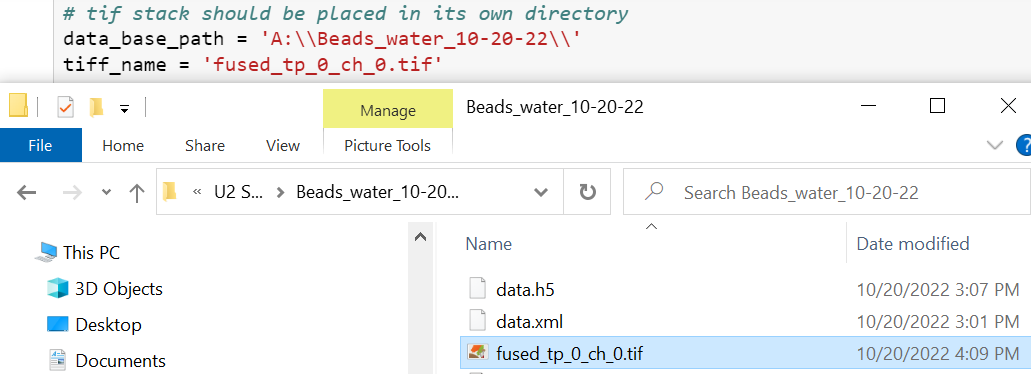
</div>

## Compute PSFs
Run this cell to generate new PSF data (may take several hours to run)

In [5]:
try: data
except NameError:
    print('Computing PSFs data')
    
    start = time.time()
    
    tiff_path = os.path.join(data_base_path,tiff_name)
    im = imread(tiff_path, plugin='tifffile')
    data, smoothed = compute(im, options)
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Execution time: {:0>2}hrs {:0>2}mins {:05.2f}secs".format(int(hours),int(minutes),seconds))
    
else: print('Error data is already defined! To recompute, delete \'data\' variable (\'del data\') and try again')


Computing PSFs data
getting centers
Smoothing...
Finding centers...
Found 44 beads
Keeping 19 beads
Finding maxima
got centers
Found bounds
Computing PSFs...
Found PSFs
Execution time: 00hrs 00mins 06.44secs


## Load PSF data
Run this cell to load saved PSF data (that has been previously generated by this script)

In [5]:
try: data
except NameError:
    print('Loading data')
    data = pandas.read_csv(os.path.join(data_base_path,'PSF_data.csv'), delimiter=',')
    print('Done')
else: print('Error data is already defined! To reload, delete \'data\' variable (\'del data\') and try again')


Loading data
Done


## Plot PSF stats

### Scatterplots

<IPython.core.display.Javascript object>


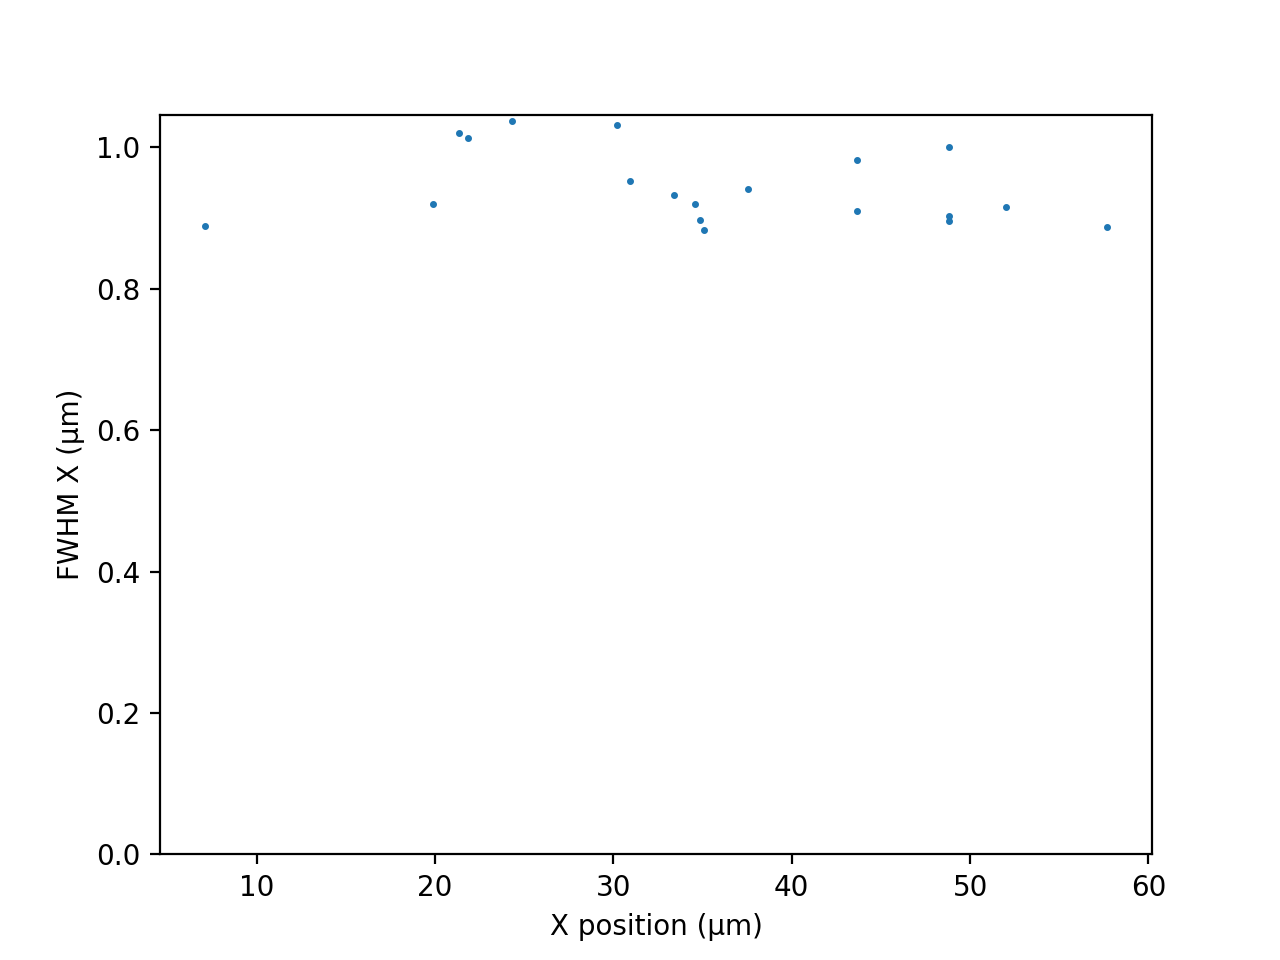

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='FWHM X (μm)'>)

In [6]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'FWHM_x'
v_label = 'FWHM X (μm)'

save_name = 'x_scatter_plot.pdf'

plot_scatter(h_ax,
             v_ax,
             save_name,
             data,
             save_plot=False,
             h_label=h_label,
             v_label=v_label,)

<IPython.core.display.Javascript object>


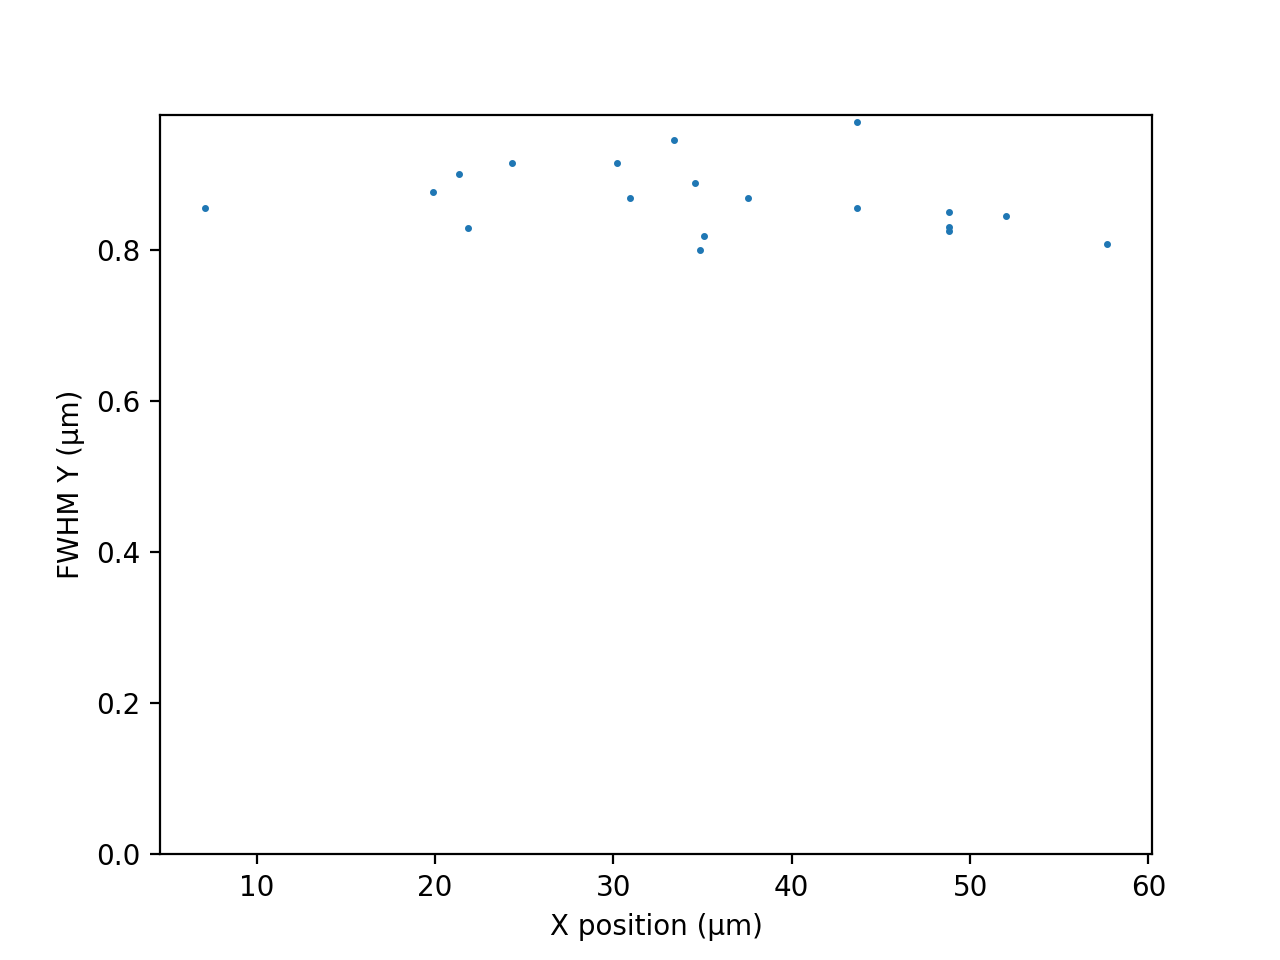

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='FWHM Y (μm)'>)

In [7]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'FWHM_y'
v_label = 'FWHM Y (μm)'

save_name = 'y_scatter_plot.pdf'

plot_scatter(h_ax,
             v_ax,
             save_name,
             data,
             save_plot=False,
             h_label=h_label,
             v_label=v_label,)

<IPython.core.display.Javascript object>


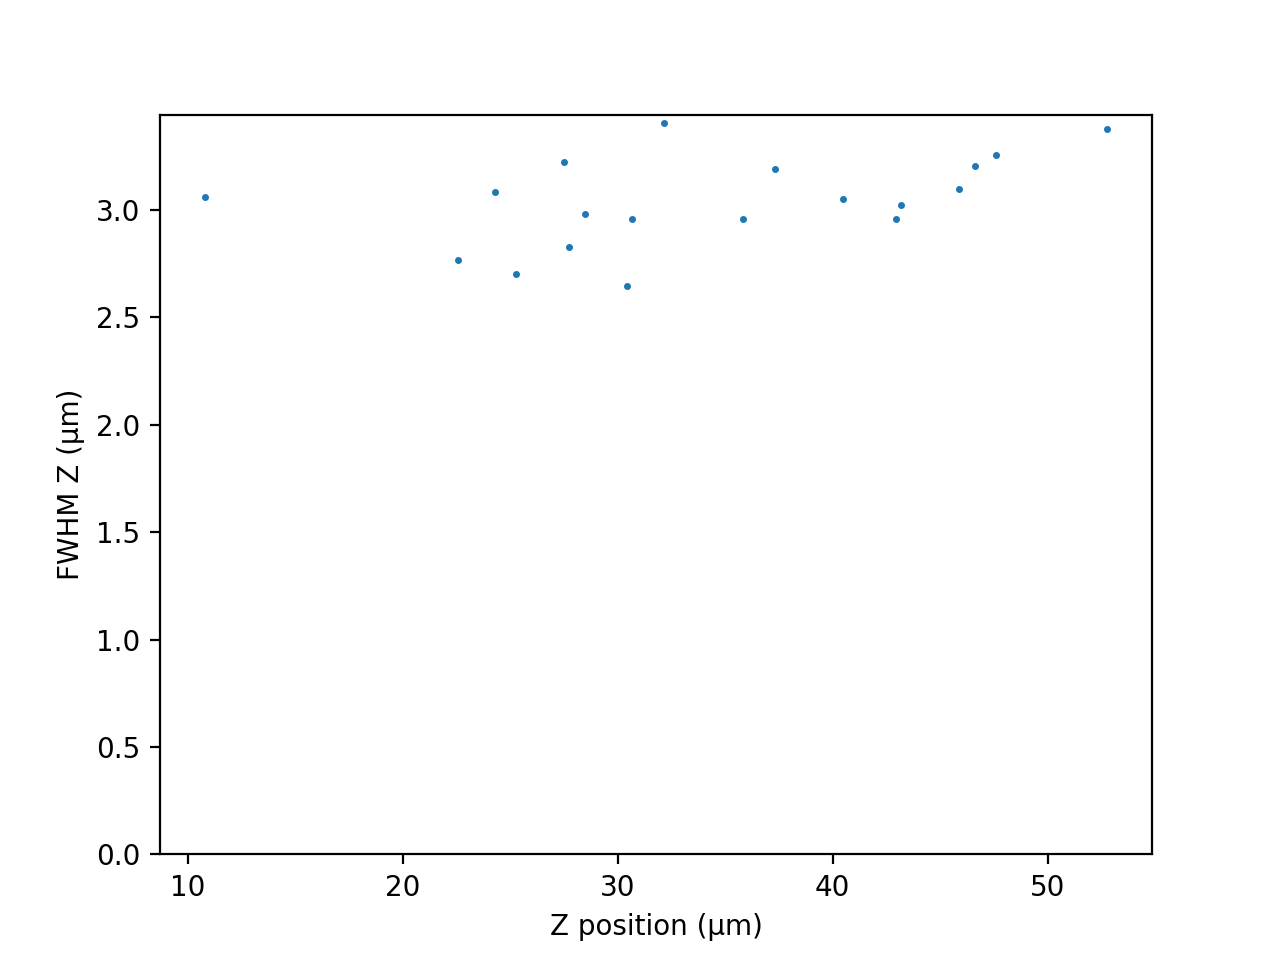

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Z position (μm)', ylabel='FWHM Z (μm)'>)

In [8]:
h_ax = 'z_center'
h_label = 'Z position (μm)'

v_ax = 'FWHM_z'
v_label = 'FWHM Z (μm)'

save_name = 'z_scatter_plot.pdf'

plot_scatter(h_ax,
             v_ax,
             save_name,
             data,
             save_plot=False,
             h_label=h_label,
             v_label=v_label,)

<IPython.core.display.Javascript object>


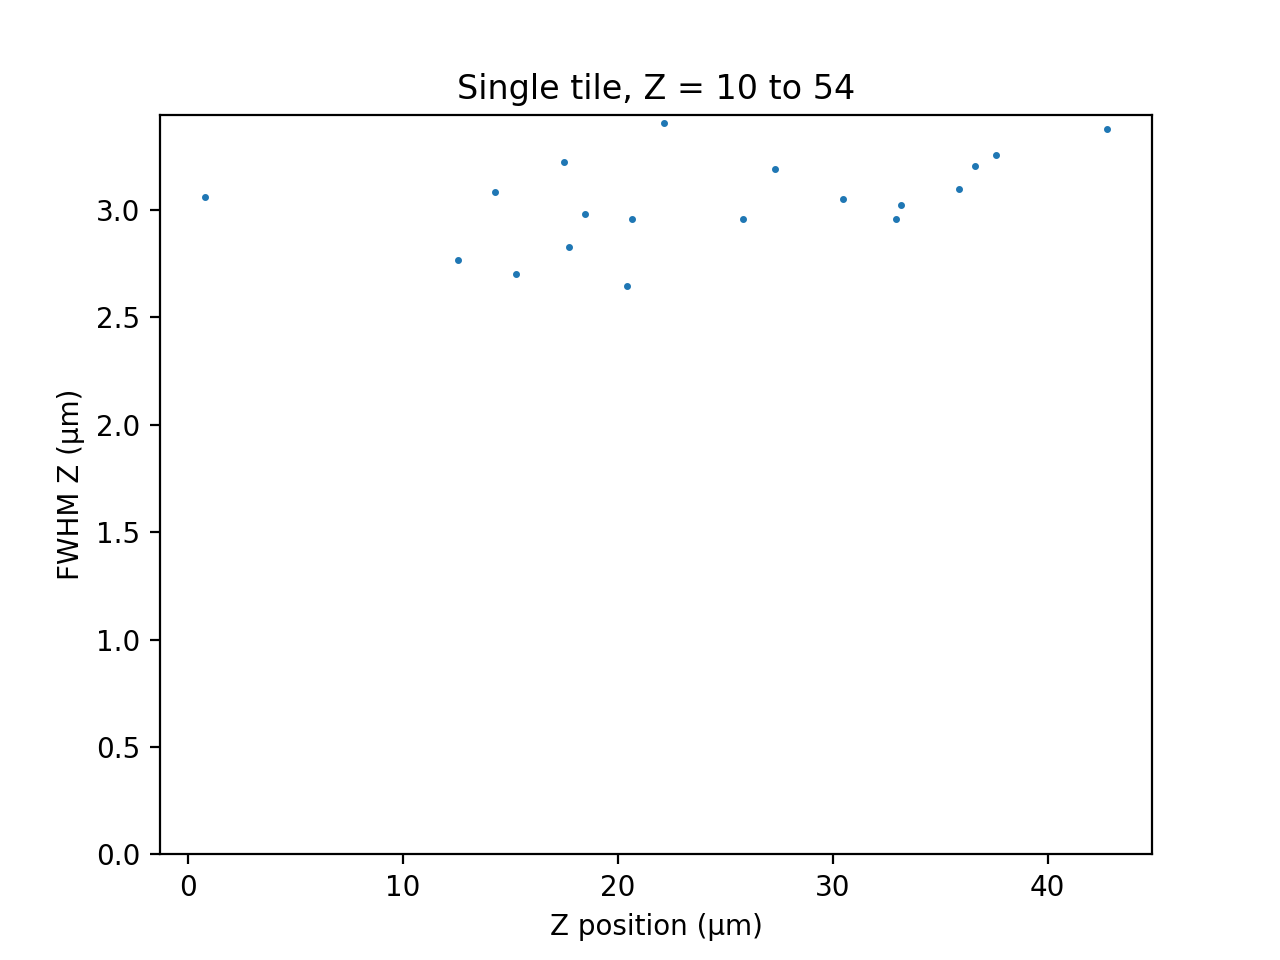

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Single tile, Z = 10 to 54'}, xlabel='Z position (μm)', ylabel='FWHM Z (μm)'>)

In [9]:
# plot only one tile
# NOTE: tile boundaries must be manually adjusted based on plot above
# multi-tile datasets may show discontinuities / artifacts at tile boundaries.
# Use this cell to manually crop data to a single tile

tile_min = 10
tile_max = 54

data_one_tile = data[(data['z_center']*sampling > tile_min) & (data['z_center']*sampling < tile_max)] 
data_one_tile['z_center'] -= tile_min/sampling

h_ax = 'z_center'
h_label = 'Z position (μm)'

v_ax = 'FWHM_z'
v_label = 'FWHM Z (μm)'

save_name = 'z_scatter_plot_single_tile.pdf'
title_string = 'Single tile, Z = ' + str(tile_min) + ' to ' + str(tile_max)

plot_scatter(h_ax,
             v_ax,
             save_name,
             data_one_tile,
             save_plot=False,
             plot_title=title_string,
             h_label=h_label,
             v_label=v_label,)


### Heatmaps

<IPython.core.display.Javascript object>


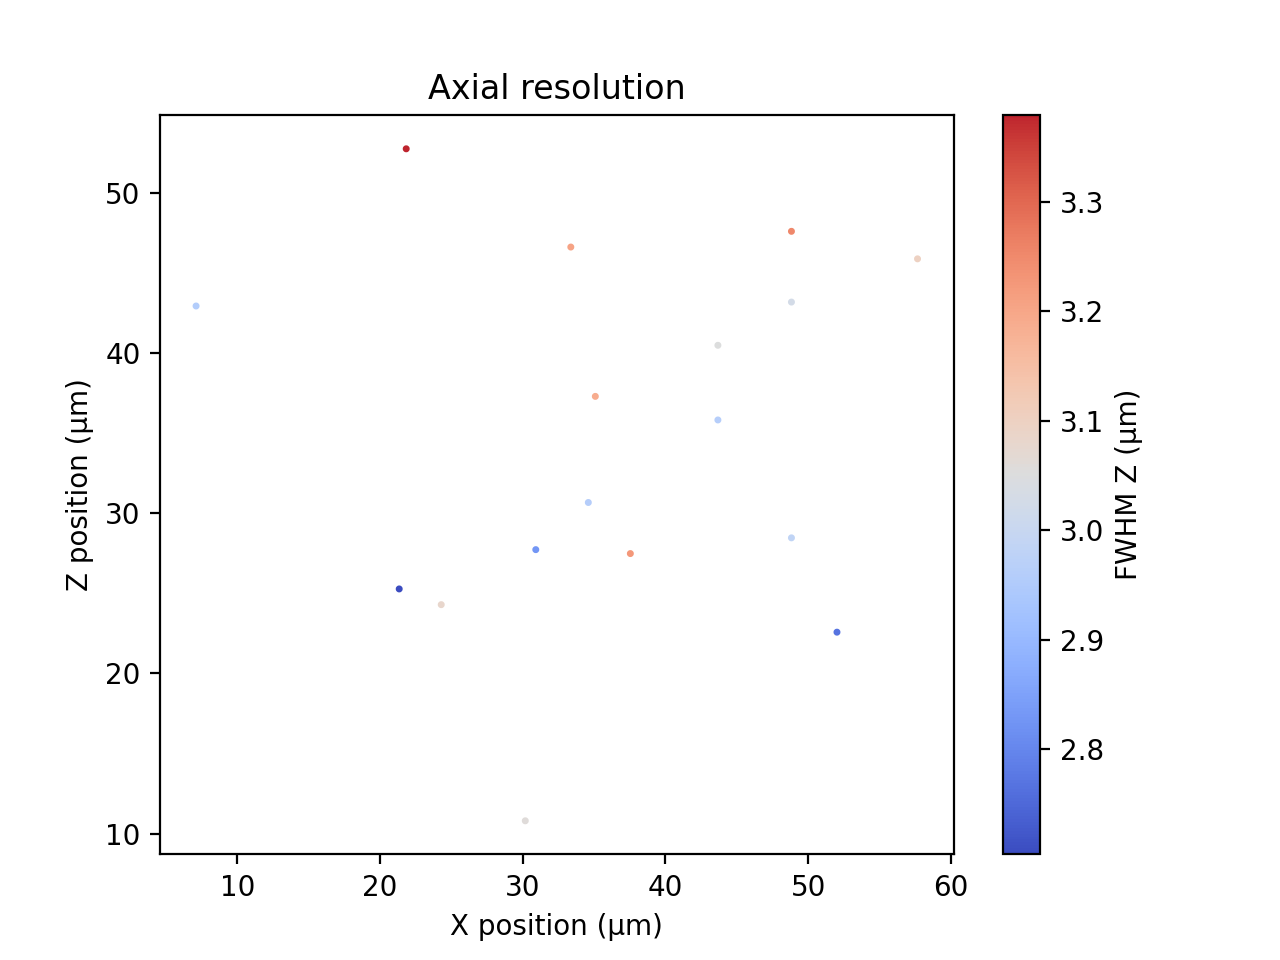

Plot NOT saved!


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Axial resolution'}, xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [10]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_z'
c_label = 'FWHM Z (μm)'

save_name = 'xz-z_heatmap.pdf'
plot_scatter_heat(h_ax,
                  v_ax,
                  color_ax,
                  save_name,
                  data,
                  save_plot=False,
                  plot_title='Axial resolution',
                  h_label=h_label,
                  v_label=v_label,
                  c_label=c_label,
                  base_map=mpl.colormaps['coolwarm'],
                 )


<IPython.core.display.Javascript object>


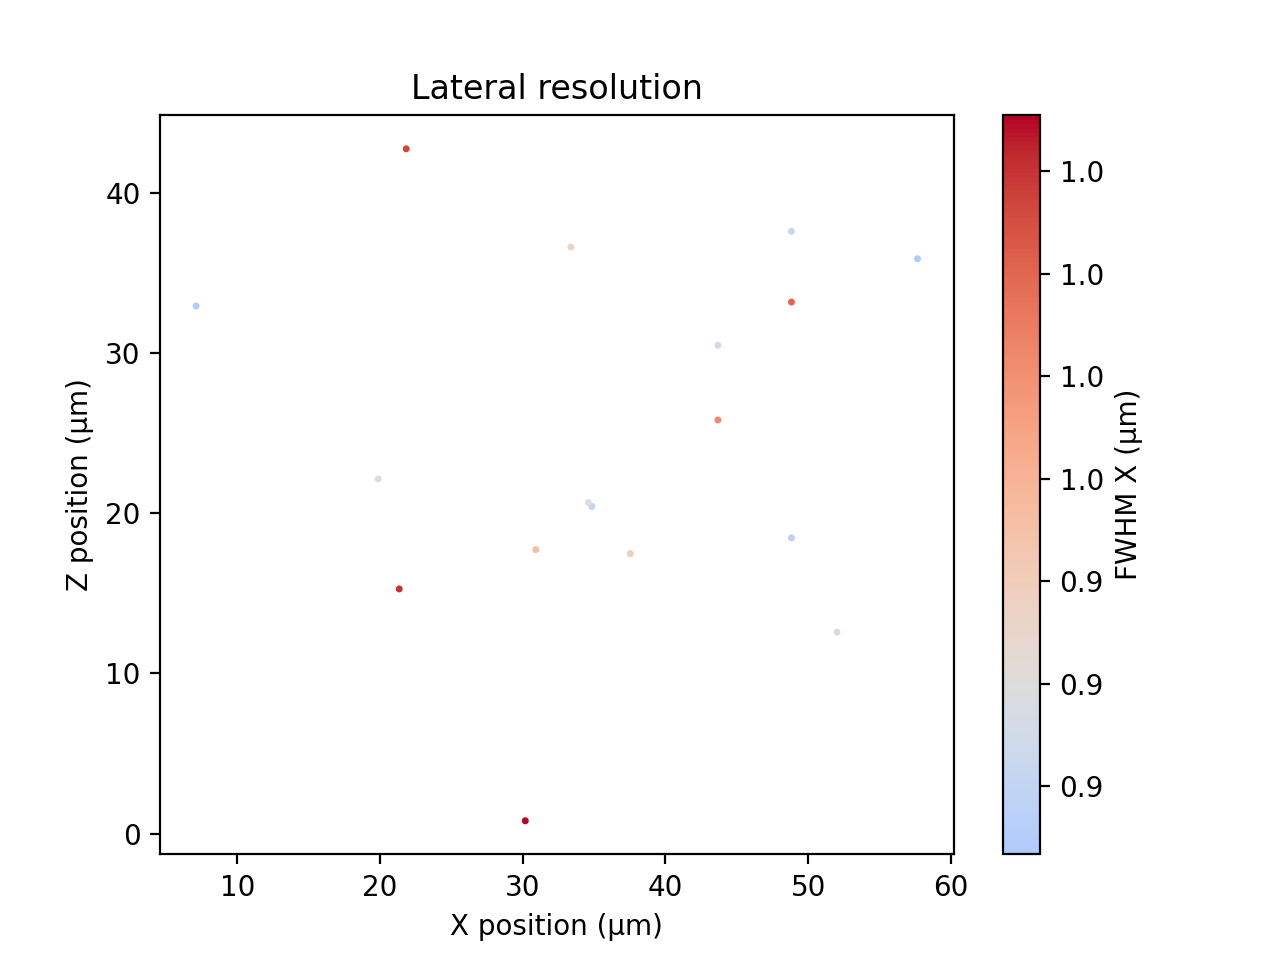

Plot NOT saved!


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Lateral resolution'}, xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [11]:
#### LATERAL ####

h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_x'
c_label = 'FWHM X (μm)'

title_string = 'Lateral resolution'

save_name = 'xz-x_heatmap_single_tile.pdf'
plot_scatter_heat(h_ax,
                  v_ax,
                  color_ax,
                  save_name,
                  data_one_tile,
                  save_plot=False,
                  h_label=h_label,
                  v_label=v_label,
                  c_label=c_label,
                  plot_title=title_string,
                  base_map=mpl.colormaps['coolwarm'],
                 )


<IPython.core.display.Javascript object>


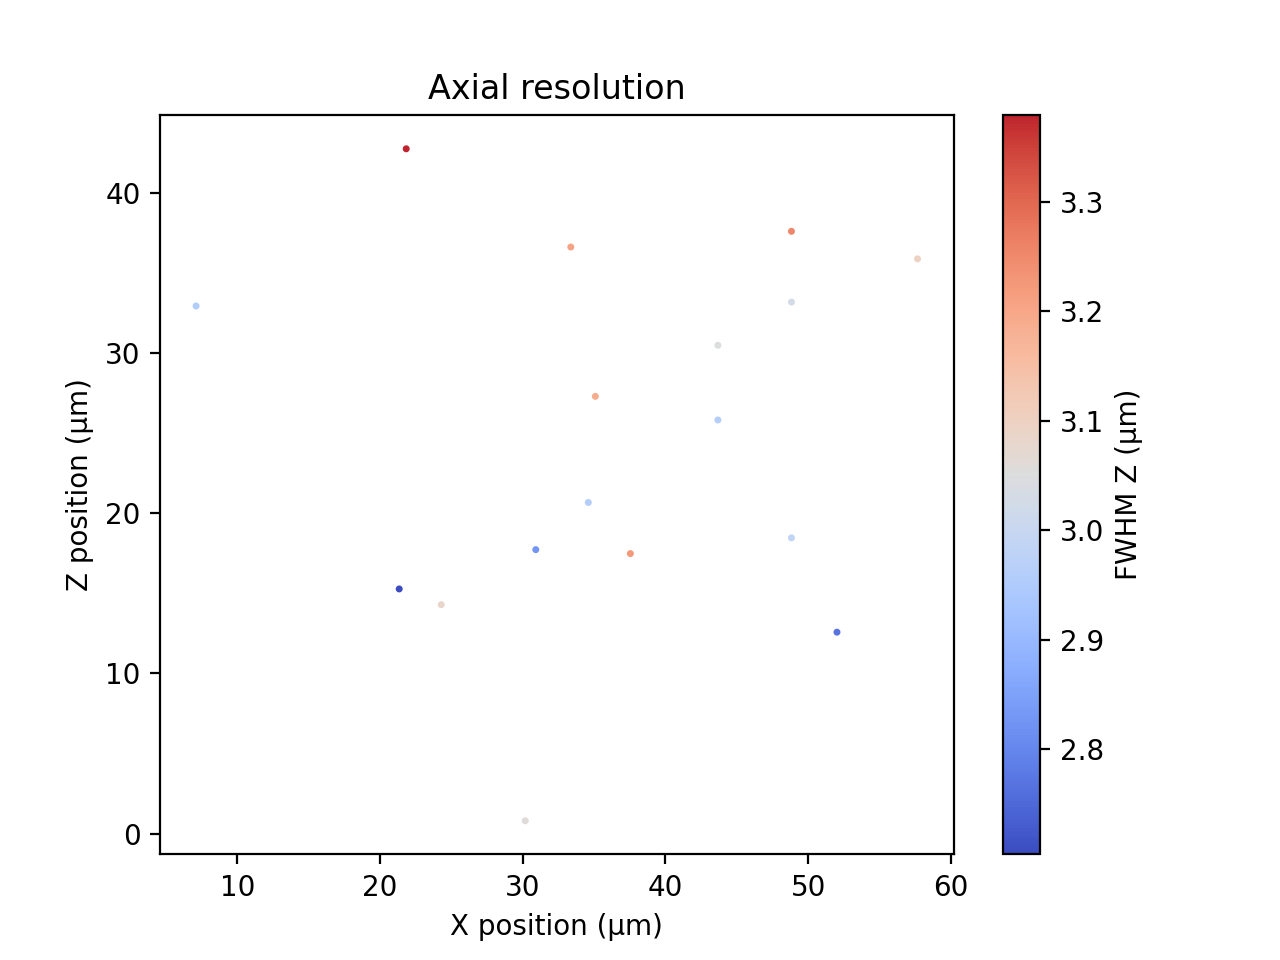

Saving plot


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Axial resolution'}, xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [12]:
#### AXIAL ####

h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_z'
c_label = 'FWHM Z (μm)'

title_string = 'Axial resolution'

save_name = 'xz-z_heatmap_single_tile.pdf'
plot_scatter_heat(h_ax,
                  v_ax,
                  color_ax,
                  save_name,
                  data_one_tile,
                  save_plot=False,
                  h_label=h_label,
                  v_label=v_label,
                  c_label=c_label,
                  plot_title=title_string,
                  base_map=mpl.colormaps['coolwarm'],
                 )

### Histograms

<IPython.core.display.Javascript object>


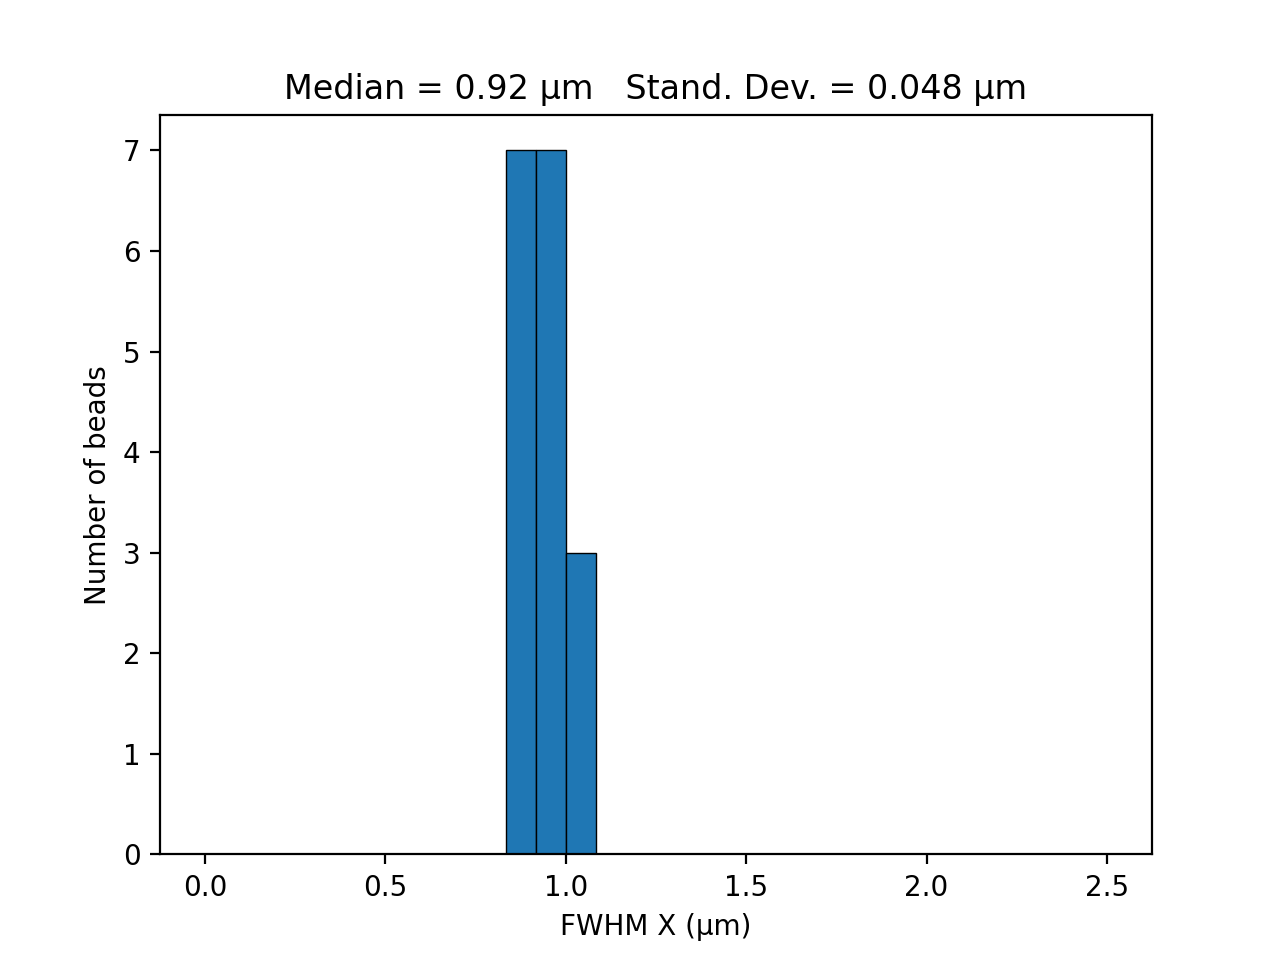

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 0.92 μm   Stand. Dev. = 0.048 μm'}, xlabel='FWHM X (μm)', ylabel='Number of beads'>)

In [13]:
h_ax = 'FWHM_x'
h_label = 'FWHM X (μm)'
v_label = 'Number of beads'
h_max_lim = 2.5
save_name = 'x_histo.pdf'

plot_histo(h_ax,
           h_max_lim,
           save_name,
           data,
           save_plot=False,
           h_label=h_label,
           v_label=v_label
          )

<IPython.core.display.Javascript object>


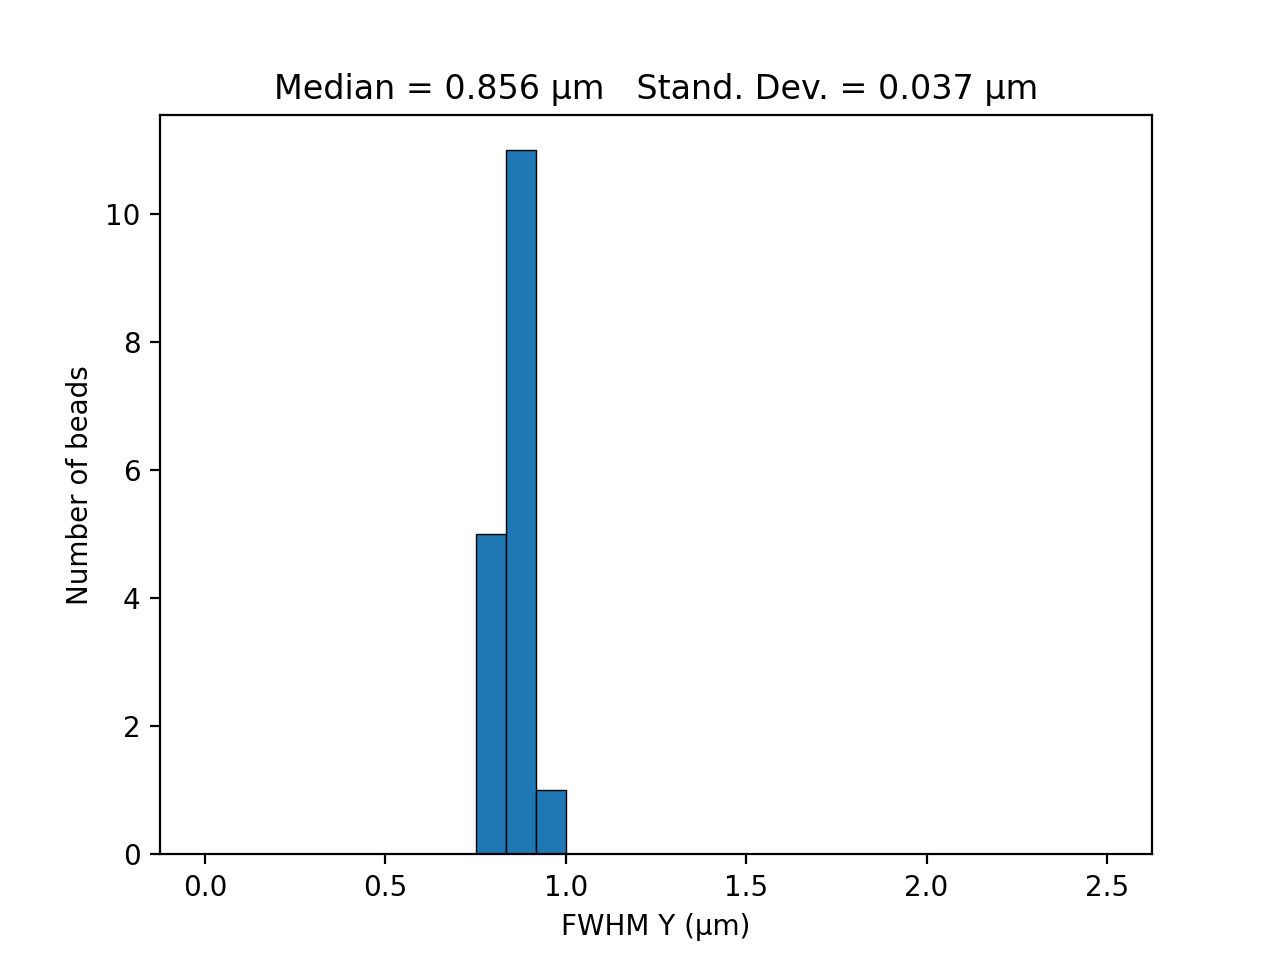

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 0.856 μm   Stand. Dev. = 0.037 μm'}, xlabel='FWHM Y (μm)', ylabel='Number of beads'>)

In [14]:
h_ax = 'FWHM_y'
h_label = 'FWHM Y (μm)'
v_label = 'Number of beads'
h_max_lim = 2.5
save_name = 'y_histo.pdf'

plot_histo(h_ax,
           h_max_lim,
           save_name,
           data,
           save_plot=False,
           h_label=h_label,
           v_label=v_label
          )

<IPython.core.display.Javascript object>


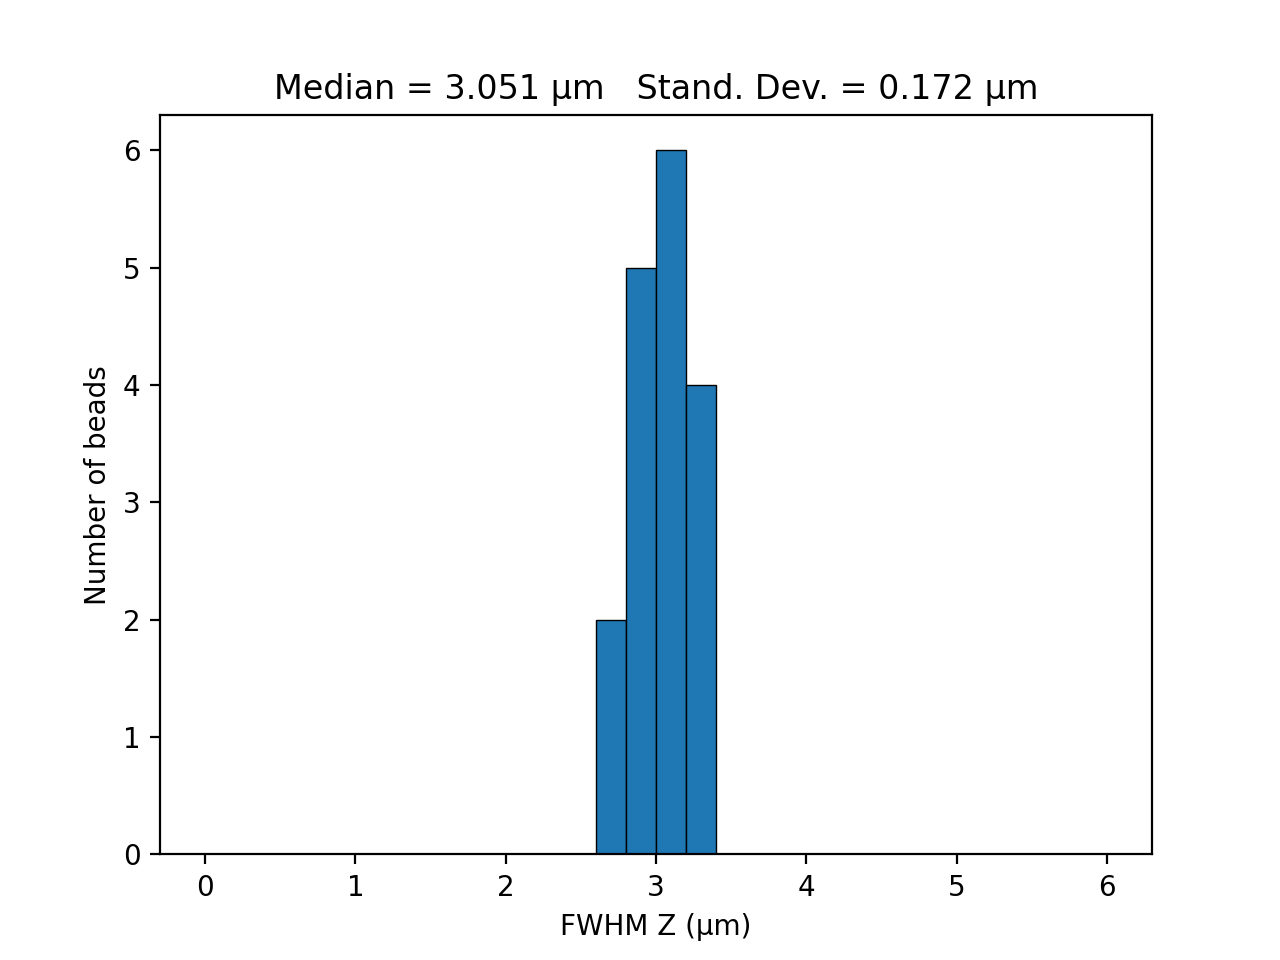

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 3.051 μm   Stand. Dev. = 0.172 μm'}, xlabel='FWHM Z (μm)', ylabel='Number of beads'>)

In [15]:
h_ax = 'FWHM_z'
h_label = 'FWHM Z (μm)'
v_label = 'Number of beads'
h_max_lim = 6.0
save_name = 'z_histo.pdf'

plot_histo(h_ax,
           h_max_lim,
           save_name,
           data,
           save_plot=False,
           h_label=h_label,
           v_label=v_label
          )

<IPython.core.display.Javascript object>


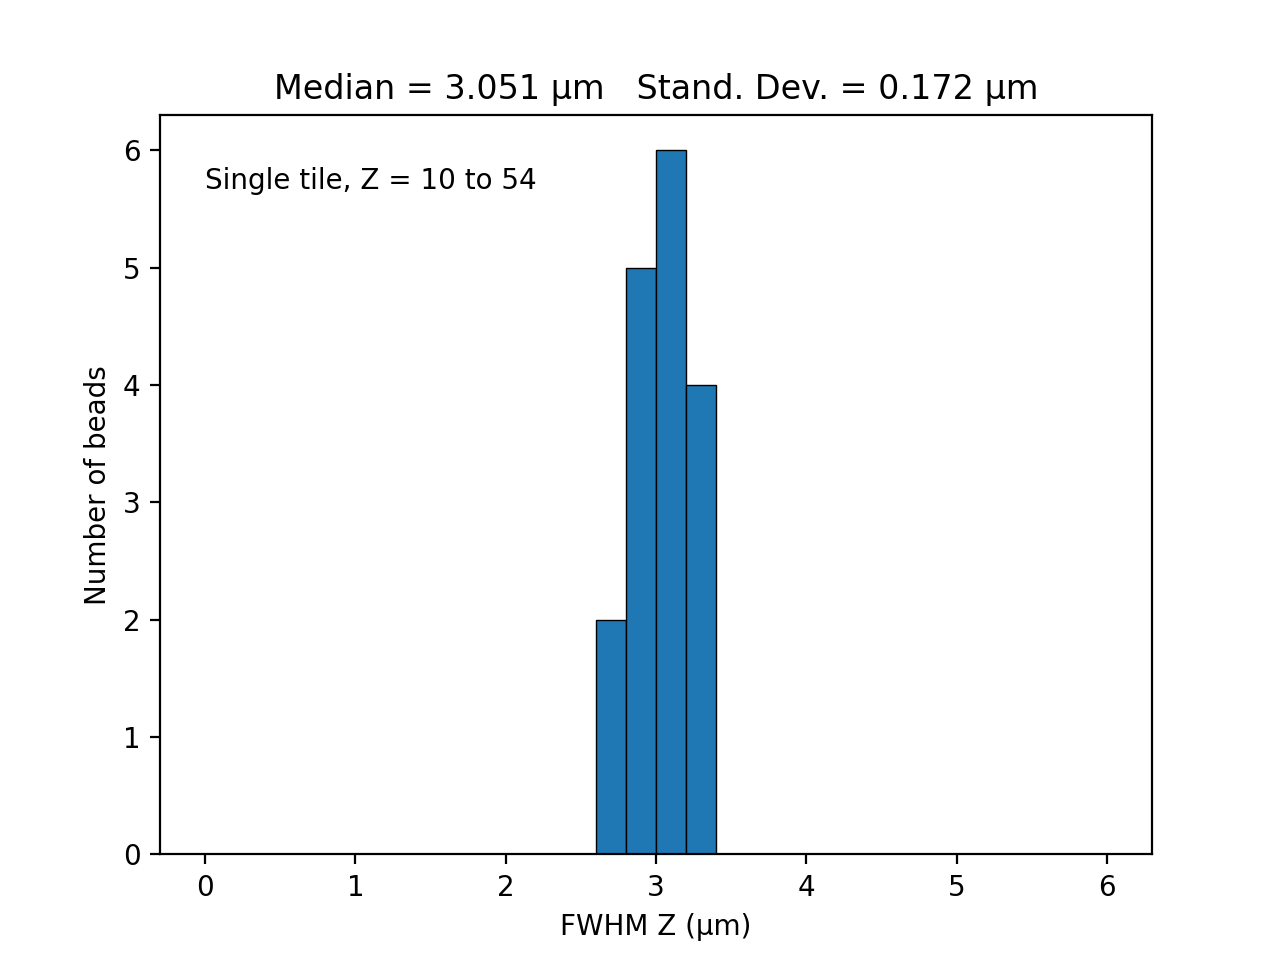

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 3.051 μm   Stand. Dev. = 0.172 μm'}, xlabel='FWHM Z (μm)', ylabel='Number of beads'>)

In [16]:
# plot single tile only (defined above)
h_ax = 'FWHM_z'
h_label = 'FWHM Z (μm)'
v_label = 'Number of beads'
h_max_lim = 6.0
save_name = 'z_histo_single_tile.pdf'
anno_string = 'Single tile, Z = ' + str(tile_min) + ' to ' + str(tile_max)

plot_histo(h_ax,
           h_max_lim,
           save_name,
           data_one_tile,
           anno=anno_string,
           save_plot=False,
           h_label=h_label,
           v_label=v_label
          )


In [ ]:
# Plot rotation histograms (see note on rotation parameter above)
# Note that demo data does not include rotation, so this cell will not work

if 'rotx' in data.columns:
    plt.subplots()
    plt.hist(data['rotx'],bins=20,fill='red',alpha=0.2)
    plt.hist(data['roty'],bins=21,fill='blue',alpha=0.2)
    plt.hist(data['rotz'],bins=22,fill='green',alpha=0.2)
else:
    raise Exception('No rotation in this dataset')


## Plot average Gaussian fit
This plot is a 2D slices of the average 3D Gaussian curve fit to the beads. Because this is computed analytically from the average fit parameters, the plot can be smoothed for any plot size. The plot will always be symmetric along the horizontal axis and along the vertical axis (even if the average PSF is not).

<IPython.core.display.Javascript object>


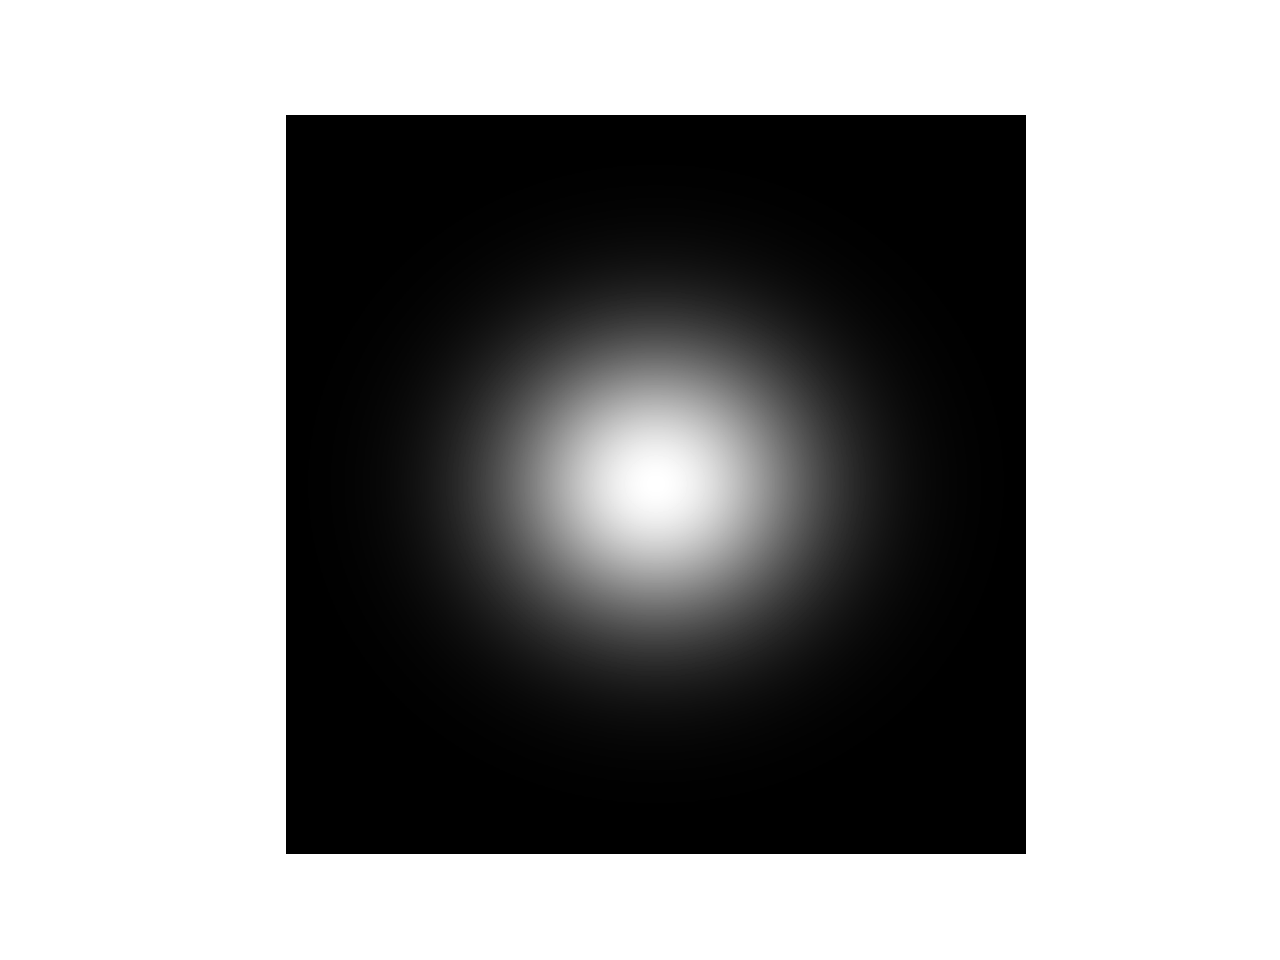

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [102]:
# 0 for x, 1 for y, 2 for z
h_ax = 0 # horizontal dimension
v_ax = 1 # vertical dimension
save_name = 'avg_fit_xy.tif'

plot_avg_fit(h_ax=h_ax,
             v_ax=v_ax,
             save_name=save_name,
             data_in=data,
             save_plot=False
            )


***
***
*The rest of the script cannot be run with loaded (previously computed) data as the complete PSFs are not stored. To run the below sections, the PSFs must be recomputed from the raw data (above)*

## Save raw data

In [35]:
save_path = os.path.join(data_base_path, 'PSF_data.csv')
if not os.path.exists(save_path):
    data.to_csv(os.path.join(data_base_path, 'PSF_data.csv'))
else:
    raise Exception('File already exists')

## Plot average PSFs (slices)
Use caution when interpreting average PSFs - some aberrations will distort the PSFs in opposite ways at each side of the field of view, etc. For instance, if a PSF stretches to have an upward tail at the left side of the FOV and a downward tail at the right side of the FOV, the average PSF would still look symmetric (as these distortions would cancel each other out).

(66, 32, 32)


<IPython.core.display.Javascript object>


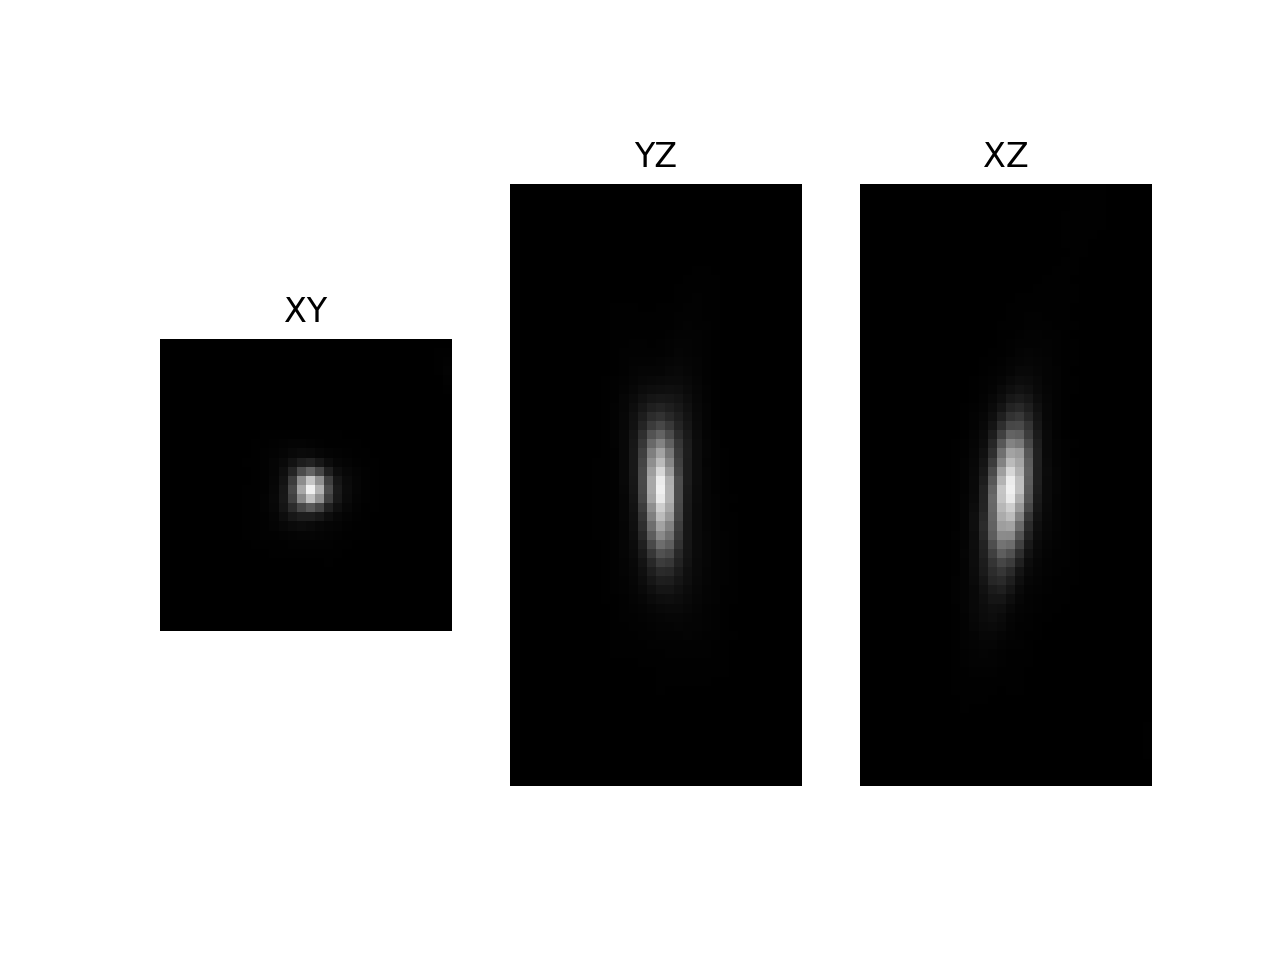

Text(0.5, 1.0, 'XZ')

In [36]:
average_psf = np.zeros(data['bead'][0].shape)
for i in range (data['bead'].shape[0]):
    average_psf = average_psf + data['bead'][i]

average_psf = average_psf/data['bead'].shape
print(average_psf.shape)
fig, axs = plt.subplots(1,3)

XY = average_psf[int(average_psf.shape[0]/2),:,:]
YZ = average_psf[:,int(average_psf.shape[1]/2),:]
XZ = average_psf[:,:,int(average_psf.shape[2]/2)]

axs[0].imshow(XY, vmin = 0, vmax = 1, cmap='gray');
axs[0].axis('off');
axs[0].set_title('XY')

axs[1].imshow(YZ, vmin = 0, vmax = 1, cmap='gray');
axs[1].axis('off');
axs[1].set_title('YZ')

axs[2].imshow(XZ, vmin = 0, vmax = 1, cmap='gray');
axs[2].axis('off');
axs[2].set_title('XZ')



In [37]:
save_path = os.path.join(data_base_path, 'XZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'YZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(YZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'XY.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XY*255).astype('uint8'))
else:
    raise Exception('File already exists')

## Plot average PSFs (projections)

<IPython.core.display.Javascript object>


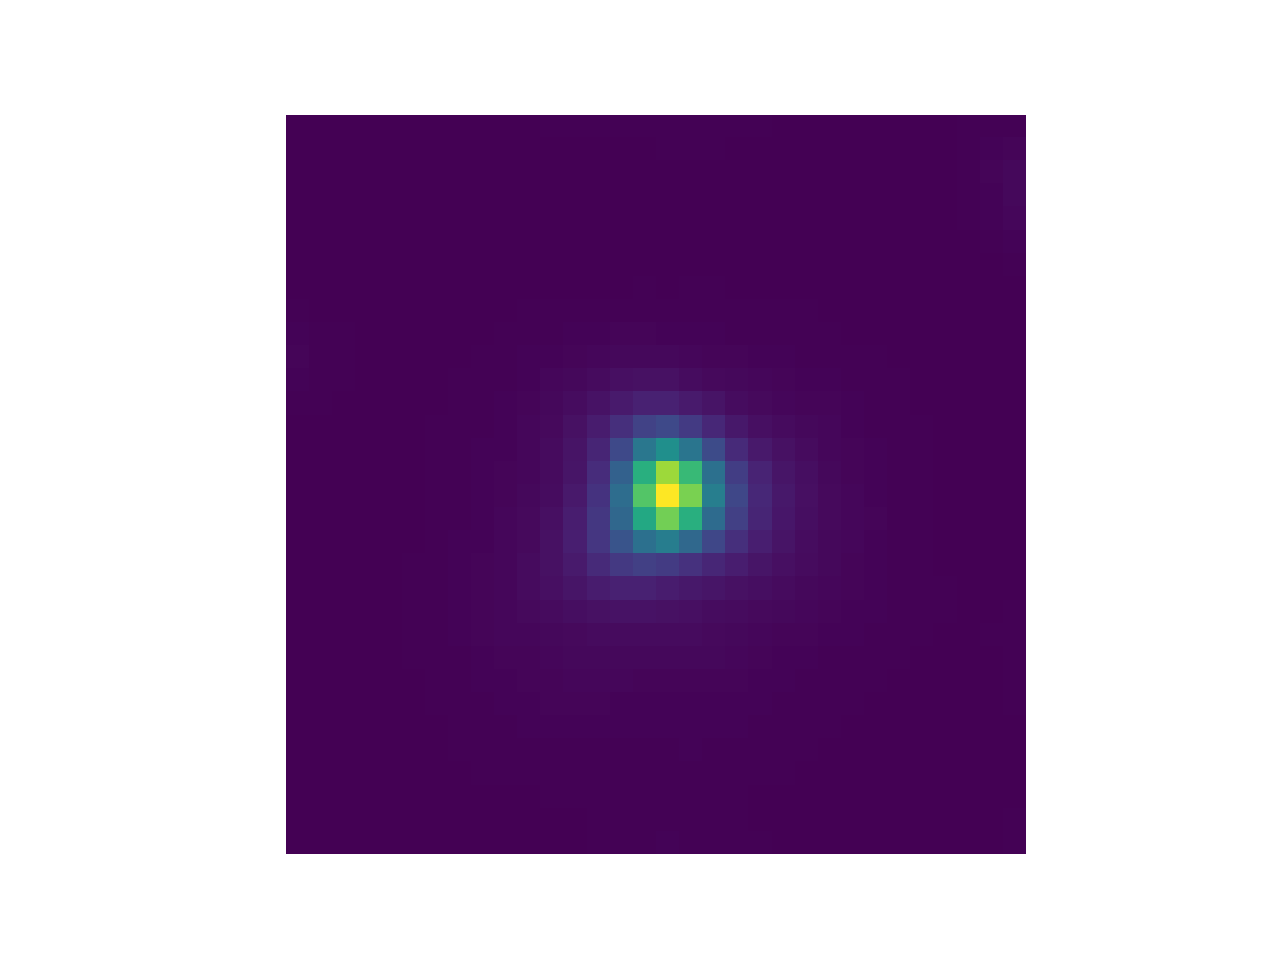

In [38]:
plt.subplots()
plt.imshow(average_psf.mean(axis=0));
plt.axis('off');

<IPython.core.display.Javascript object>


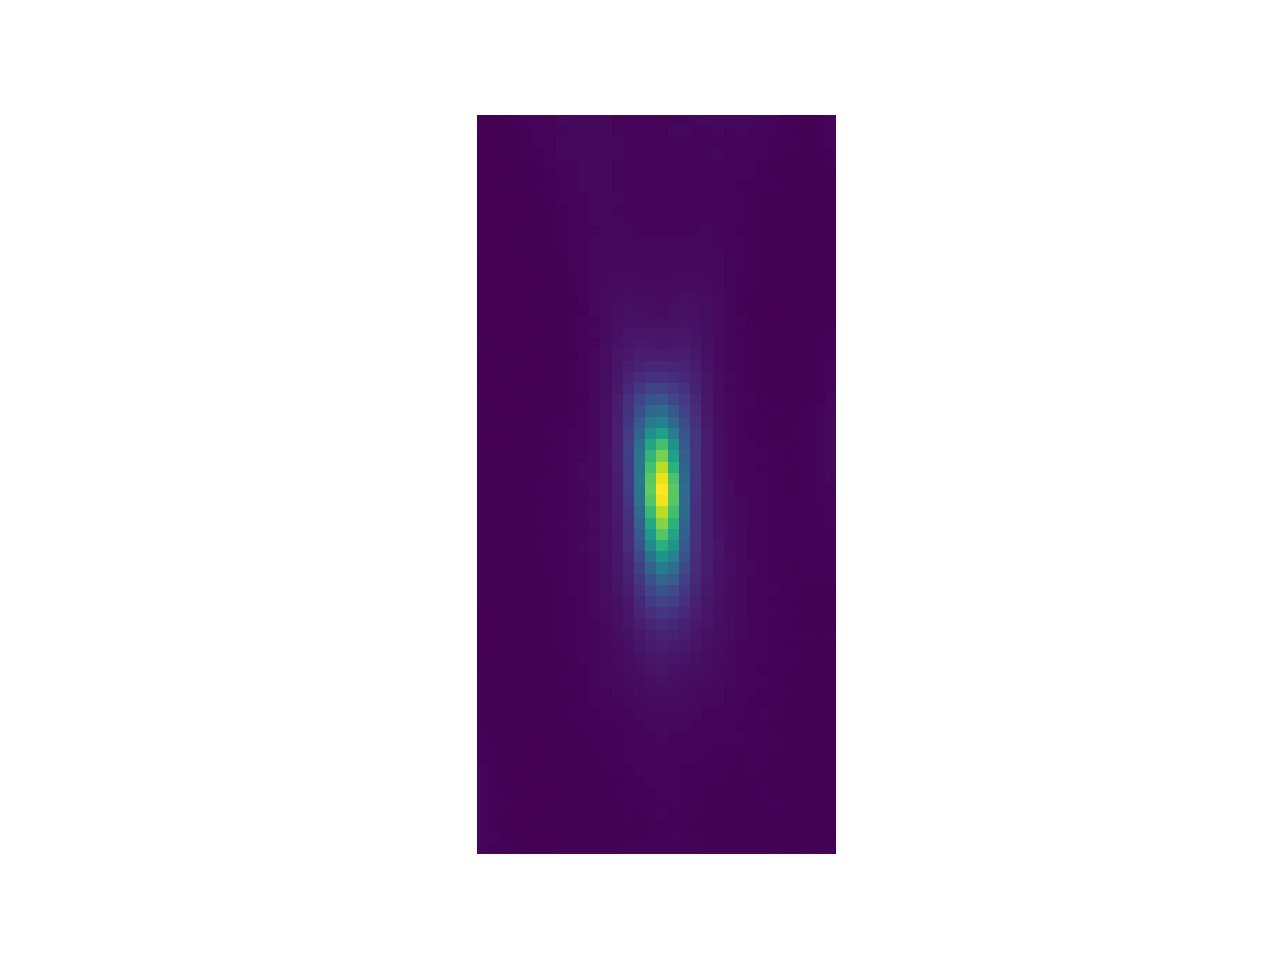

In [39]:
plt.subplots()
plt.imshow(average_psf.mean(axis=1), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

<IPython.core.display.Javascript object>


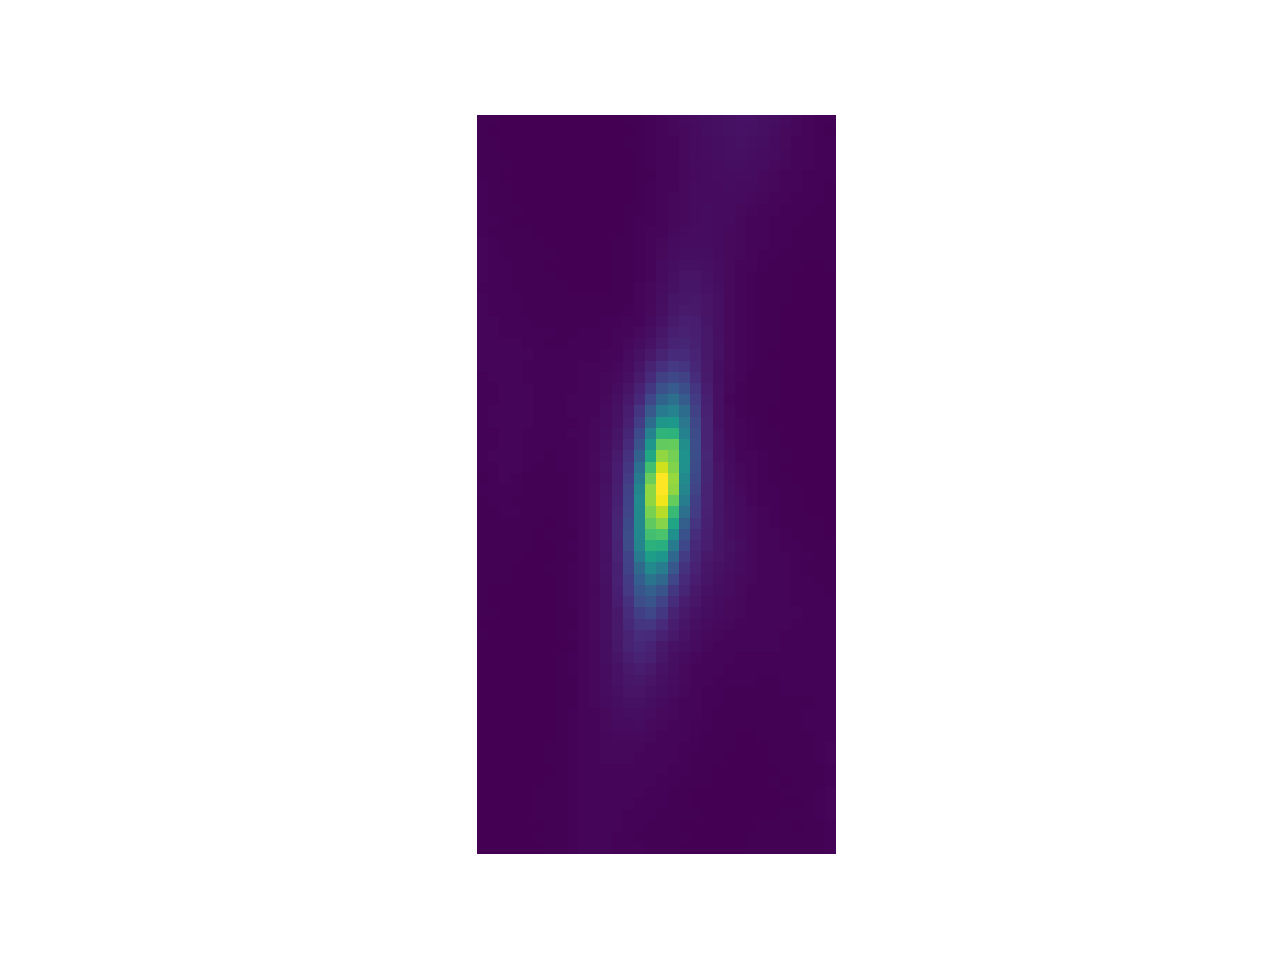

In [40]:
plt.subplots()
plt.imshow(average_psf.mean(axis=2), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

## Plot max projection of bead locations

<IPython.core.display.Javascript object>


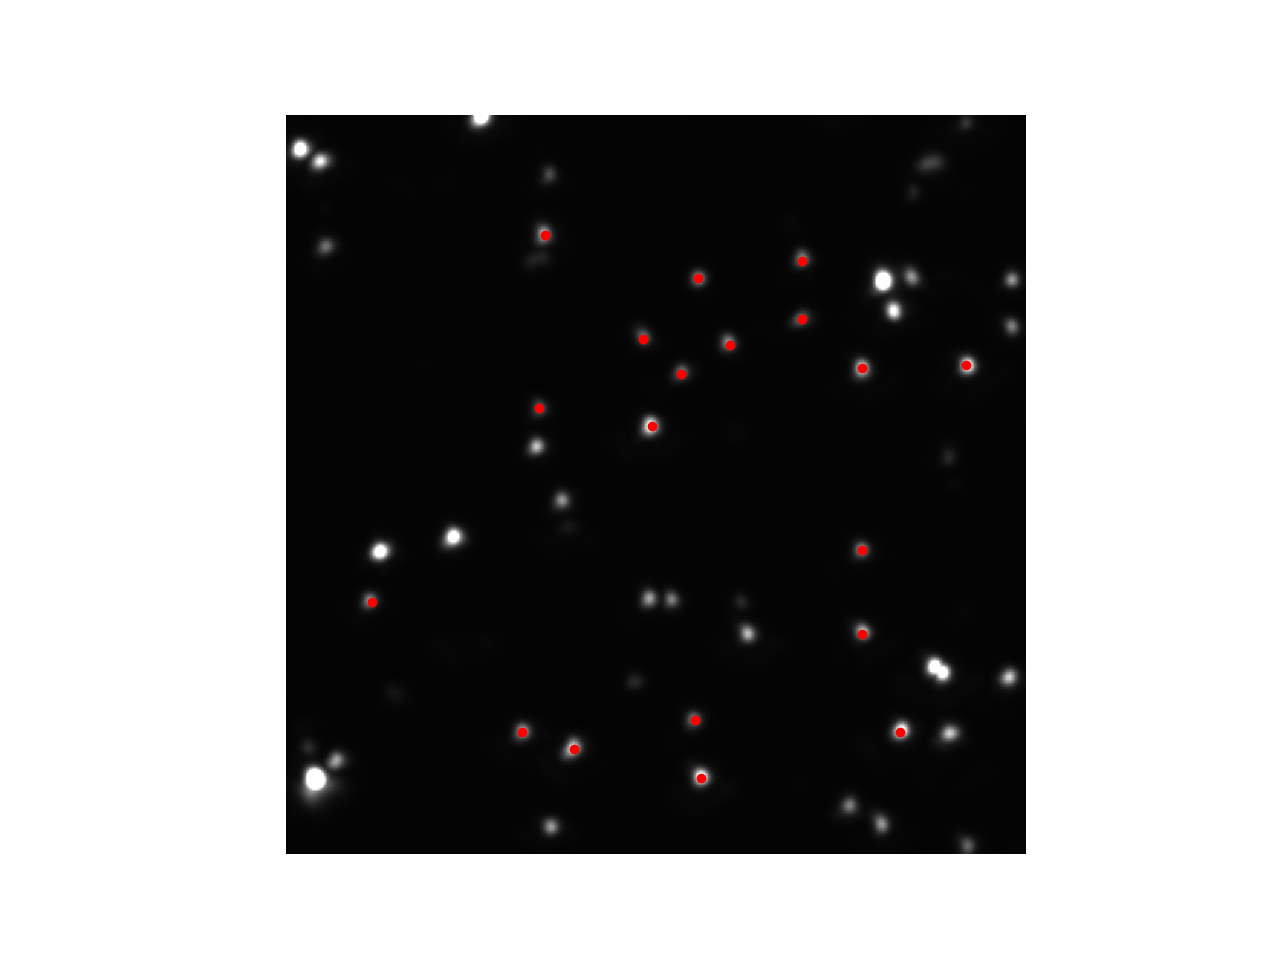

In [43]:
plt.subplots()
plt.imshow(smoothed, vmin = 0, vmax = 10000, cmap='gray');
plt.plot(data['x_center'], data['y_center'], 'r.', ms=5);

# uncomment below to zoom in on plot
# plt.xlim([0, 0+smoothed.shape[0]/4])
# plt.ylim([smoothed.shape[1]/4, 500])
plt.axis('off');